In [1]:
import numpy as np
import matplotlib.pyplot as plt


class Flipflop():

    def __init__(self, n_bits, random_seed=42):
      
        self.n_bits = n_bits
        self.random_gen_ = np.random.RandomState(random_seed)

    def reset_state(self):
    
        return self.random_gen_.choice([+1,-1], size=self.n_bits)

    def next_state(self, prev_state, input_):
     
        return np.array([-e if e==-p else e for e, p in zip(prev_state, input_)])

In [2]:
def generate_data(flipflop, n, p_zero, random_seed=42):


    random_gen_ = np.random.RandomState(random_seed)

    # Possible choices for input signals (initialized with [0,..0])
    in_choices = [[0]*flipflop.n_bits]
    for i in range(flipflop.n_bits):
        tmp = [0]*flipflop.n_bits

        tmp[i] = +1
        in_choices.append(tmp.copy())

        tmp[i] = -1
        in_choices.append(tmp.copy())
        
    # Initialize the probability of each input signals
    in_prob = np.concatenate(([p_zero], [(1-p_zero)/(len(in_choices)-1)]
                                        *(len(in_choices)-1)))

    input_data = np.zeros((n, flipflop.n_bits))
    output_data = np.zeros((n, flipflop.n_bits))

    # Assigning the initial flipflop state to the first output signal
    output_data[0] = flipflop.reset_state()

    for t in range(1, n):
        rnd_indx = random_gen_.choice(len(in_choices), 1, p=in_prob)[0]
        input_data[t] = in_choices[rnd_indx]
        output_data[t] = flipflop.next_state(output_data[t-1, :], 
                                             input_data[t, :])
        
    return input_data, output_data

In [3]:
class ESN():

    def __init__(self, n_in, n_out=None, n_resv=350, ridge_alpha=1e-8, 
                 state_noise=1e-3, feedback_noise=1e-3, spec_rad=0.02, 
                 sparsity=0.05,random_seed=42, verbose=False):
       
            #n_in: input size of the network
            #n_out: output size of the network (same as n_in if None)
            #n_resv: reservoir size of the network
            #ridge_alpha: A nonnegative number for the smoothing effect in,the ridge regression
            #state_noise: white noise added to the network for regularization
            #feedback_noise: white noise added to the network feedback for 
                          #  robustness against unstable feedback
            #spec_rad: maximum spectral radius for the reservoir weight matrix
            #sparsity: sparsity of the reservoir weight matrix (0, 1]
            
        self.n_in = n_in
        self.n_out = n_out if n_out else n_in
        self.n_resv = int(n_resv)
        self.ridge_alpha = ridge_alpha
        self.state_noise = state_noise
        self.feedback_noise = feedback_noise
        self.spec_rad = spec_rad
        self.sparsity = sparsity
        self.random_seed = random_seed
        self.random_gen_ = np.random.RandomState(random_seed)
        self.verbose = verbose

        self._init_weights()

    def _init_weights(self):
        
        self.W_in = self.random_gen_.uniform(-1, 1, (self.n_resv, self.n_in))

        self.W_fb = self.random_gen_.uniform(-1, 1, (self.n_resv, self.n_out))

        self.W_res = self.random_gen_.uniform(-1, 1, (self.n_resv, self.n_resv))

        # randomly remove some connections
        rand_idxs = self.random_gen_.rand(*self.W_res.shape) < (1 - self.sparsity)
        self.W_res[rand_idxs] = 0

        # rescale to reach the maximum spectral radius
        curr_radius = np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_res = self.W_res * (self.spec_rad / curr_radius)

    def _get_resv(self, x_t, u_t_, y_t):
       
        return (np.tanh(self.W_res @ x_t + self.W_in @ u_t_ + self.W_fb @ y_t) + 
                self.random_gen_.normal(size=(self.n_resv)) * self.state_noise)

    def _harvest(self, U, D):
      
        n_max = U.shape[0] # dataset size
        X = np.zeros((n_max, self.n_resv)) # matrix of reservoir states
        # Added noise to the output
        D += self.random_gen_.normal(size=D.shape) * self.feedback_noise

        #tq = tqdm(range(1, n_max), disable=(not self.verbose), desc='Harvesting')
        for t in range(1, n_max):
            X[t] = self._get_resv(X[t-1], U[t], D[t-1])
        
        S = np.hstack((X, U)) # extended system states (n_max, n_resv + n_in)
            
        return S

    def _ridge_reg(self, S, D):
      
        n_max = S.shape[0] # dataset size
        R = (1/n_max) * (S.T @ S) # (n_resv + n_in, n_resv + n_in)
        I = np.eye(self.n_resv + self.n_in) # (n_resv + n_in, n_resv + n_in)
        P = (1/n_max) * (S.T @ D) # (n_resv + n_in, n_out)

        self.W_out = np.linalg.inv(R + self.ridge_alpha**2 * I) @ P # (n_resv + n_in, n_out)
        # self.W_out = (np.linalg.pinv(S) @ D)

    def reset(self):
      
        self.random_gen_ = np.random.RandomState(self.random_seed)
        self._init_weights()

    def learn(self, inputs, outputs):
      
        S = self._harvest(inputs, outputs)
        self._ridge_reg(S, outputs)

    def predict(self, inputs):
      
        n_max = inputs.shape[0]
        prev_x = np.zeros(self.n_resv)
        prev_u = inputs[0]
        prev_y = np.hstack((prev_x,prev_u)) @ self.W_out
        outputs = np.zeros((n_max, self.n_out))

       # tq = tqdm(range(1, n_max), disable=(not self.verbose), desc='Predicting')
        for t in range(1, n_max):
            prev_x = self._get_resv(prev_x, prev_u, prev_y)
            prev_y = np.hstack((prev_x, prev_u)) @ self.W_out
            outputs[t-1] = prev_y.copy()
            prev_u = inputs[t]

        prev_x = self._get_resv(prev_x, prev_u, prev_y)
        outputs[-1] = np.hstack((prev_x, prev_u)) @ self.W_out

        return outputs

In [4]:
def plot_signals(n, target_out, model_out=None, inputs=None, n_t=500):

    fig, axs = plt.subplots(n)
    #fig, axs = plt.pyplot.subplots(n)
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['figure.dpi'] = 100

    for i in range(n):
        axs[i].plot(np.arange(n_t), target_out[:n_t,i], label='target')
        if model_out is not None: 
            axs[i].plot(np.arange(n_t), model_out[:n_t,i], label='model')
        if inputs is not None:
            axs[i].plot(np.arange(n_t), inputs[:n_t,i], label='input', alpha=0.9)
    
    axs[0].legend(loc="upper right")
    plt.show()

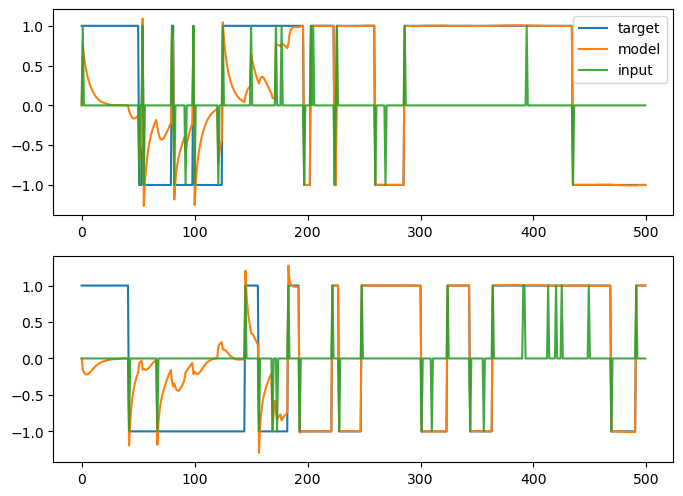

In [54]:
N = 2
ff = Flipflop(N)
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)
test_in, test_out = generate_data(ff, 500, p_zero=0.9, random_seed=77)

esn = ESN(N, feedback_noise=0, verbose=True)
esn.learn(train_in, train_out)
train_pr=esn.predict(train_in)
test_pr = esn.predict(test_in)

#mse, nrmse = metrics(test_pr, test_out)
#print("MSE:{} NRMSE:{}".format(mse, nrmse))
plot_signals(N, test_out, test_pr, test_in, n_t=500)


In [69]:
def MC(train_out, train_pr,n_k):
    
     
    mc_tk=[]
    N=50
    
    mean_train_out = np.mean(train_out, axis=0)
    mean_train_pr = np.mean(train_pr, axis=0)
    std_train_out = np.std(train_out, axis=0)
    std_train_pr = np.std(train_pr, axis=0)
    #.reshape((1, 2))
    
    for k in range(n_k):
        mc_t=0
        
        for t in range(100,1000):

            num = (train_out[t-k, :] - mean_train_out) * (train_pr[t, :] - mean_train_pr)
            
            #num = np.cov(train_out[t-k, :],train_pr[t, :])
            
            mc = np.power(num / ((N-1) * std_train_out * std_train_pr),2)
            
            #mc = np.power((num)/(np.var(train_out[t, :])*np.var(train_pr[t, :])),2)
            
            
            mc_t = mc + mc_t
            
  
        mc_tk.append(mc_t)
    
    return mc_tk    



In [70]:
mc= MC(train_out, train_pr,n_k=5)
print(mc)
plt.plot(mc,n_k=5)
plt.show()

[array([0.3977027 , 0.41509621]), array([0.3973431 , 0.41480559]), array([0.39698487, 0.41440253]), array([0.39664992, 0.41399839]), array([0.39647514, 0.41363147])]


In [64]:
train_in, train_out = generate_data(ff, 6000, p_zero=0.9, random_seed=42)

train_pr=esn.predict(train_in)



(6000, 2)